# **Import Libraries**

In [1]:
import random
import warnings
import ipywidgets as widgets
from IPython.display import display

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from nltk.translate.bleu_score import corpus_bleu

from data_loader import NMTDataModule

# **Ignoring Any Warning Messages**

In [2]:
warnings.filterwarnings('ignore')

# **Hyperparameters**

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

embed_size, hidden_size, num_layers, lstm_dropout = 256, 512, 2, 0.3

batch_size, learning_rate, max_epochs, teacher_forcing_ratio = 32, 1e-3, 10, 0.5

# **Tokenizer**

In [4]:
! unzip resources.zip

Archive:  resources.zip
   creating: resources/
   creating: resources/parallel_en_fr_corpus/
  inflating: resources/parallel_en_fr_corpus/dataset_dict.json  
   creating: resources/parallel_en_fr_corpus/test/
  inflating: resources/parallel_en_fr_corpus/test/dataset.arrow  
  inflating: resources/parallel_en_fr_corpus/test/dataset_info.json  
  inflating: resources/parallel_en_fr_corpus/test/state.json  
   creating: resources/parallel_en_fr_corpus/train/
  inflating: resources/parallel_en_fr_corpus/train/dataset.arrow  
  inflating: resources/parallel_en_fr_corpus/train/dataset_info.json  
  inflating: resources/parallel_en_fr_corpus/train/state.json  
   creating: resources/parallel_en_fr_corpus/validation/
  inflating: resources/parallel_en_fr_corpus/validation/dataset.arrow  
  inflating: resources/parallel_en_fr_corpus/validation/dataset_info.json  
  inflating: resources/parallel_en_fr_corpus/validation/state.json  
   creating: resources/tokenizer_en/
  inflating: resources/tok

In [5]:
dm = NMTDataModule(data_path = "resources/parallel_en_fr_corpus", tokenizer_en_path = "resources/tokenizer_en", tokenizer_fr_path = "resources/tokenizer_fr", batch_size = batch_size)
train_loader, val_loader, test_loader = dm.get_dataloaders()

src_vocab_size, trg_vocab_size = len(dm.tokenizer_fr), len(dm.tokenizer_en)
pad_idx = dm.tokenizer_en.pad_token_id

Loading tokenizers...

--- Tokenizer Sanity Check ---
Input: 'hello' -> IDs: [1, 51, 67, 22, 2]
Decoded: '<s> ▁he ll o </s>'
Starts with BOS (1)? True
Ends with EOS (2)? True
Tokenizer is correctly adding special tokens.
------------------------------

Loading dataset...


# **Encoder**

In [6]:
class Encoder(nn.Module):
    def __init__(self, src_vocab_size, embed_size, hidden_size, num_layers, lstm_dropout):
        super().__init__()
        self.embedding = nn.Embedding(src_vocab_size, embed_size)
        self.dropout = nn.Dropout(lstm_dropout)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first = True, dropout = lstm_dropout, bidirectional = True)

    def forward(self, x):
        output, (h_n, c_n) = self.lstm(self.dropout(self.embedding(x)))
        return output, (h_n, c_n)

# **Decoder**

In [7]:
class Decoder(nn.Module):
    def __init__(self, trg_vocab_size, embed_size, hidden_size, num_layers, lstm_dropout):
        super().__init__()
        self.num_layers = num_layers
        self.embedding = nn.Embedding(trg_vocab_size, embed_size)
        self.dropout = nn.Dropout(lstm_dropout)
        self.W_init = nn.Linear(hidden_size * 2, hidden_size)
        self.W, self.U, self.v = nn.Linear(hidden_size, hidden_size), nn.Linear(hidden_size * 2, hidden_size), nn.Linear(hidden_size, 1, bias = False)
        self.W_out = nn.Linear(hidden_size * 3 + embed_size, trg_vocab_size)
        self.lstm = nn.LSTM(embed_size + hidden_size * 2, hidden_size, num_layers, batch_first = True, dropout = lstm_dropout)

    def initialize_hidden_state(self, encoder_state):
        h_n, c_n = encoder_state
        s0 = torch.tanh(self.W_init(torch.cat((h_n[-2], h_n[-1]), dim = 1))).unsqueeze(0).repeat(self.num_layers, 1, 1) # (batch-size, hidden_size) -> (num_layers, batch-size, hidden-size)
        c0 = torch.tanh(self.W_init(torch.cat((c_n[-2], c_n[-1]), dim = 1))).unsqueeze(0).repeat(self.num_layers, 1, 1)
        return s0, c0

    def forward(self, s_prev, y_prev, encoder_output):
        embedded = self.dropout(self.embedding(y_prev))
        energy = self.v(torch.tanh(self.W(s_prev[0][-1]).unsqueeze(1) + self.U(encoder_output))) # (batch-size, hidden-state) -> (batch_size, sequence_length, hidden_state)
        alphas = torch.softmax(energy, dim = 1)
        context = torch.bmm(alphas.transpose(1, 2), encoder_output) # (batch-size, seq_len, 1) -> (batch-size, 1, seq_len) * (batch-size, seq_len, hidden-state)
        output, s_curr = self.lstm(torch.cat((embedded, context), dim = 2), s_prev)
        logits = self.W_out(torch.cat((output.squeeze(1), context.squeeze(1), embedded.squeeze(1)), dim = 1)) # (batch-size, (1) seq_len, _), (batch-size, _)
        return logits, s_curr, alphas

# **Seq2Seq**

In [8]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device, teacher_forcing_ratio = 0):
        super().__init__()
        self.encoder, self.decoder, self.device, self.ratio = encoder, decoder, device, teacher_forcing_ratio

    def forward(self, src, trg):
        outputs = torch.zeros(src.shape[0], trg.shape[1], self.decoder.W_out.out_features).to(self.device)
        enc_out, enc_state = self.encoder(src)
        dec_state = self.decoder.initialize_hidden_state(enc_state)
        input_token = trg[:, 0].unsqueeze(1) # (batch_size) -> # (batch_size, seq_len) required for the lstm input

        for t in range(1, trg.shape[1]):
            output, dec_state, _ = self.decoder(dec_state, input_token, enc_out)
            outputs[:, t] = output
            input_token = trg[:, t].unsqueeze(1) if random.random() < self.ratio else output.argmax(1).unsqueeze(1) # argmax(1) across dim 1
        return outputs

    def beam_search_decode(self, src, max_len, beam_size):
        self.eval()
        with torch.no_grad():
            enc_out, enc_state = self.encoder(src)
            dec_state = self.decoder.initialize_hidden_state(enc_state)
            beam = [(0.0, [1], dec_state)]

            for _ in range(1, max_len):
                candidates = []
                for score, seq, s_prev in beam:
                    if seq[-1] == 2:
                        candidates.append((score, seq, s_prev))
                        continue

                    dec_input = torch.tensor([[seq[-1]]]).to(self.device)
                    out, s_curr, _ = self.decoder(s_prev, dec_input, enc_out)

                    log_probs, indices = torch.log_softmax(out.squeeze(0), dim = -1).topk(beam_size)

                    for i in range(beam_size):
                        new_score = score + log_probs[i].item()
                        new_seq = seq + [indices[i].item()]
                        candidates.append((new_score, new_seq, s_curr))

                beam = sorted(candidates, key=lambda x: x[0], reverse = True)[:beam_size]

                if all(seq[-1] == 2 for _, seq, _ in beam):
                    break

            return torch.tensor(beam[0][1]).to(self.device)

    def translate_with_attention(self, src, trg_len, tokenizer_en):
        self.eval()
        with torch.no_grad():
            enc_out, enc_state = self.encoder(src)
            dec_state = self.decoder.initialize_hidden_state(enc_state)
            attn_matrix, inputs, trans_toks = torch.zeros(trg_len, src.shape[1]).to(self.device), torch.tensor([[1]]).to(self.device), [1]

            for t in range(1, trg_len):
                out, dec_state, alpha = self.decoder(dec_state, inputs, enc_out)
                attn_matrix[t] = alpha.squeeze(0).squeeze(-1)
                pred = out.argmax(1).item()
                trans_toks.append(pred)
                if pred == 2: break
                inputs = torch.tensor([[pred]]).to(self.device)
            return trans_toks, attn_matrix[:len(trans_toks), :]

# **Training**

In [9]:
encoder = Encoder(src_vocab_size, embed_size, hidden_size, num_layers, lstm_dropout).to(device)
decoder = Decoder(trg_vocab_size, embed_size, hidden_size, num_layers, lstm_dropout).to(device)
model = Seq2Seq(encoder, decoder, device, teacher_forcing_ratio).to(device)
optimizer, criterion = optim.Adam(model.parameters(), lr=learning_rate), nn.CrossEntropyLoss(ignore_index=pad_idx)
best_valid_loss, save_path = float('inf'), 'best_model.pt'

for epoch in range(max_epochs):
    model.train()
    epoch_loss = 0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
        src, trg = batch['src_ids'].to(device), batch['trg_ids_full'].to(device)
        optimizer.zero_grad()
        output = model(src, trg)
        loss = criterion(output[:, 1:].reshape(-1, output.shape[-1]), trg[:, 1:].reshape(-1))
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        epoch_loss += loss.item()

    model.eval()
    with torch.no_grad():
        val_loss = sum(criterion(model(b['src_ids'].to(device), b['trg_ids_full'].to(device))[:, 1:].reshape(-1, output.shape[-1]), b['trg_ids_full'].to(device)[:, 1:].reshape(-1)).item() for b in val_loader) / len(val_loader)

    print(f'Epoch: {epoch+1} | Train: {epoch_loss/len(train_loader):.4f} | Val: {val_loss:.4f}')
    if val_loss < best_valid_loss: best_valid_loss, _ = val_loss, torch.save(model.state_dict(), save_path)

Epoch 1: 100%|██████████| 272/272 [00:15<00:00, 17.15it/s]


Epoch: 1 | Train: 3.3146 | Val: 2.6953


Epoch 2: 100%|██████████| 272/272 [00:14<00:00, 18.27it/s]


Epoch: 2 | Train: 2.4671 | Val: 2.2943


Epoch 3: 100%|██████████| 272/272 [00:14<00:00, 18.26it/s]


Epoch: 3 | Train: 1.9271 | Val: 1.9249


Epoch 4: 100%|██████████| 272/272 [00:15<00:00, 17.76it/s]


Epoch: 4 | Train: 1.4627 | Val: 1.7428


Epoch 5: 100%|██████████| 272/272 [00:14<00:00, 18.71it/s]


Epoch: 5 | Train: 1.0411 | Val: 1.6701


Epoch 6: 100%|██████████| 272/272 [00:14<00:00, 18.13it/s]


Epoch: 6 | Train: 0.7288 | Val: 1.6197


Epoch 7: 100%|██████████| 272/272 [00:14<00:00, 18.65it/s]


Epoch: 7 | Train: 0.5117 | Val: 1.6322


Epoch 8: 100%|██████████| 272/272 [00:14<00:00, 18.61it/s]


Epoch: 8 | Train: 0.3883 | Val: 1.5801


Epoch 9: 100%|██████████| 272/272 [00:14<00:00, 18.56it/s]


Epoch: 9 | Train: 0.2785 | Val: 1.6078


Epoch 10: 100%|██████████| 272/272 [00:14<00:00, 18.21it/s]


Epoch: 10 | Train: 0.2237 | Val: 1.6744


# **Load Best Model**

In [10]:
model.load_state_dict(torch.load(save_path))

<All keys matched successfully>

# **Compute BLEU Score**

In [11]:
def calculate_bleu(data_loader, model, tokenizer, device, max_len=32, beam_size=5):
    model.eval()
    targets, outputs = [], []
    with torch.no_grad():
        for batch in tqdm(data_loader, desc="Calculating BLEU"):
            for i in range(batch['src_ids'].shape[0]):
                pred = model.beam_search_decode(batch['src_ids'][i].unsqueeze(0).to(device), max_len, beam_size)
                outputs.append(tokenizer.decode(pred.tolist(), skip_special_tokens=True).split())
                targets.append([tokenizer.decode(batch['trg_ids_full'][i], skip_special_tokens=True).split()])
    return corpus_bleu(targets, outputs)

In [12]:
print(f'BLEU-4: {calculate_bleu(test_loader, model, dm.tokenizer_en, device) * 100:.2f}')

Calculating BLEU: 100%|██████████| 16/16 [00:16<00:00,  1.01s/it]

BLEU-4: 54.29


# **Plot Attention**

In [13]:
def plot_attention_heatmap(src_tokens, trg_tokens, attn):
    plt.figure(figsize=(10, 10))
    sns.heatmap(attn.cpu().numpy(), annot=False, cmap='Blues', xticklabels=src_tokens, yticklabels=trg_tokens)
    plt.show()

Visualizing 5 examples...

------------------------------------------------------------
Example 1
Source:      ▁on ▁peut ▁me ▁faire ▁confiance ▁.
Translation: ▁i ▁m ▁being ▁used ▁to ▁do ▁it ▁.


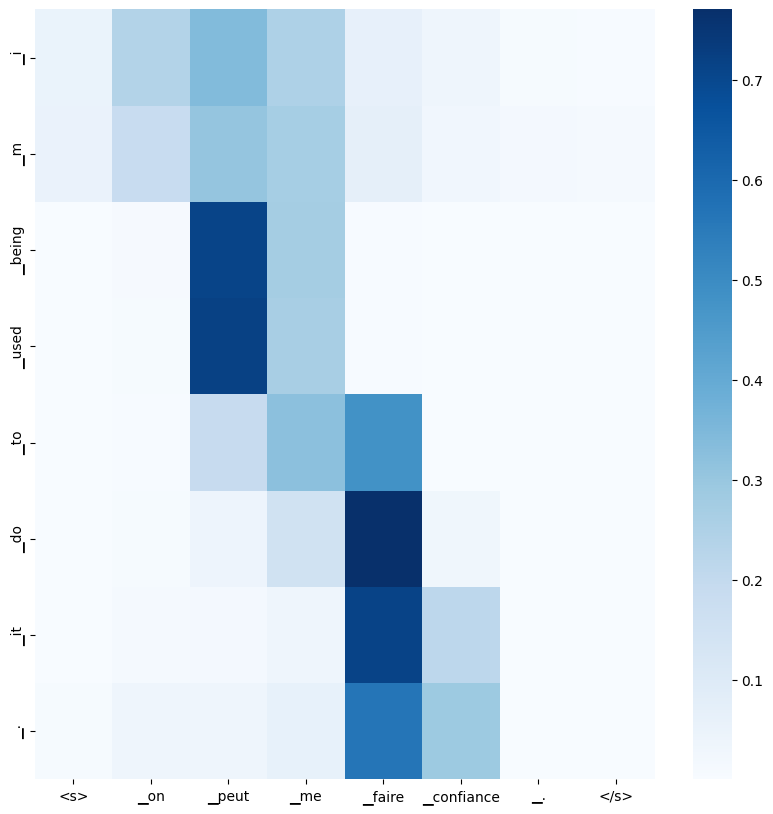

------------------------------------------------------------
Example 2
Source:      ▁je ▁ne ▁suis ▁pas ▁mal heure ux ▁.
Translation: ▁i ▁m ▁not ▁mis able ▁.


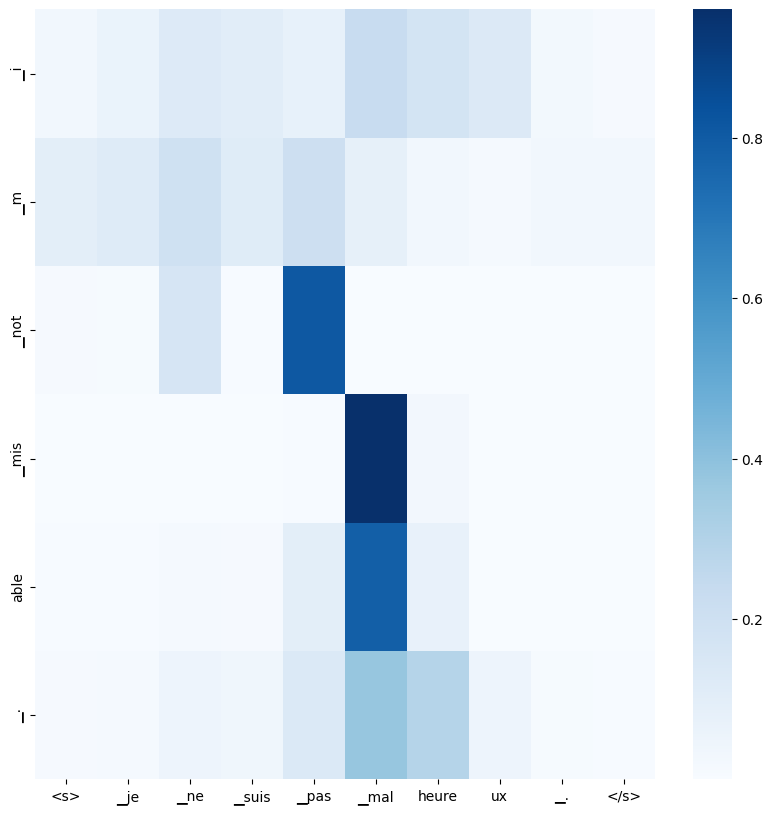

------------------------------------------------------------
Example 3
Source:      ▁je ▁vais ▁prendre ▁ma ▁voiture ▁.
Translation: ▁i ▁m ▁going ▁to ▁drive ▁my ▁car ▁.


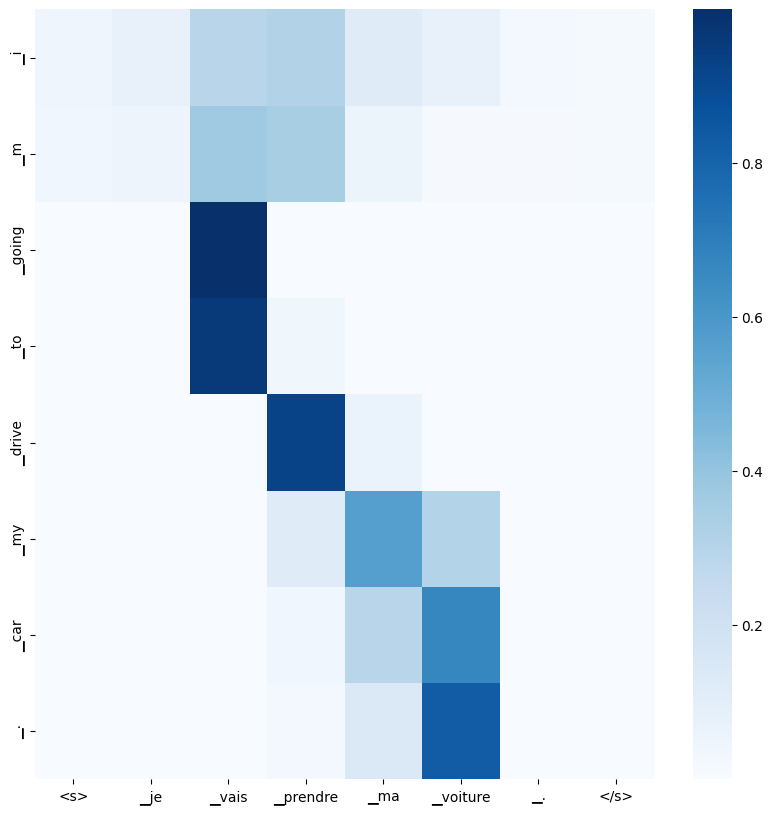

------------------------------------------------------------
Example 4
Source:      ▁il ▁adore ▁les ▁chats ▁.
Translation: ▁he ▁s ▁very ▁fond ▁cat ▁.


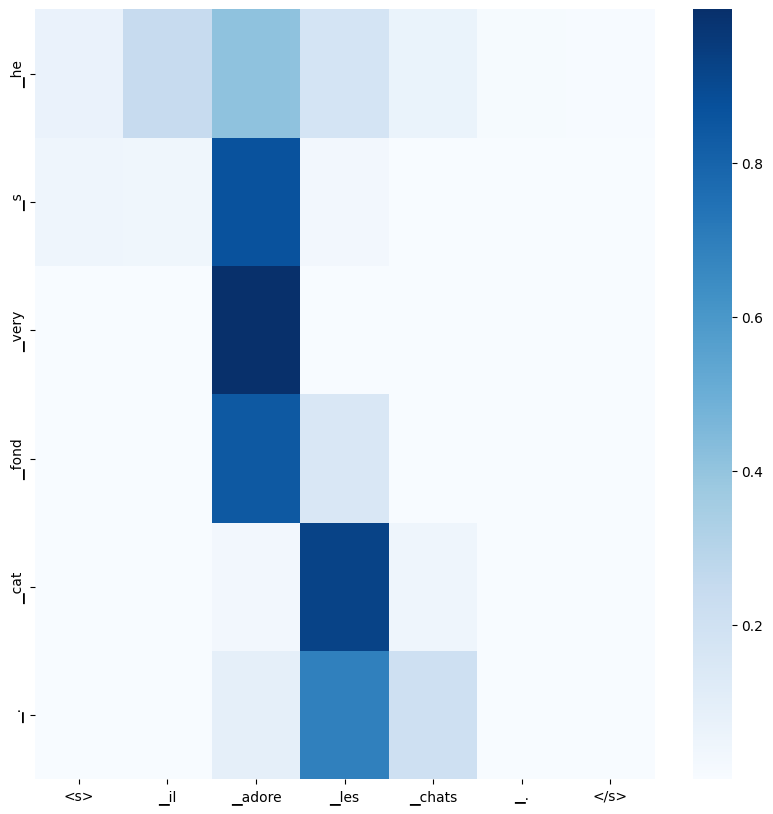

------------------------------------------------------------
Example 5
Source:      ▁j ▁en ▁suis ▁contente ▁.
Translation: ▁i ▁m ▁happy ▁with ▁that ▁.


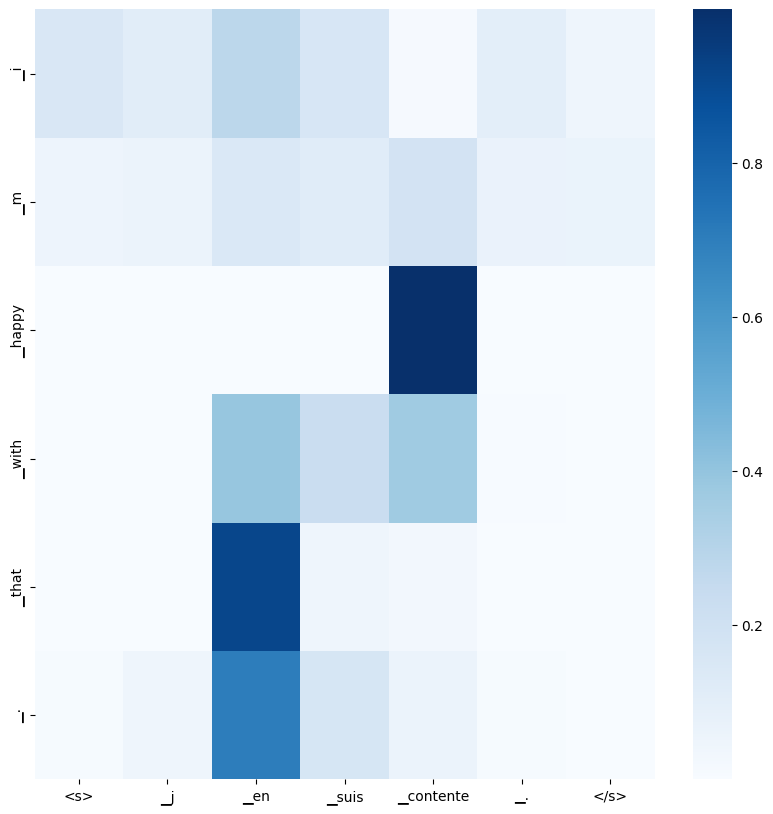

In [14]:
num_examples = 5

batch = next(iter(test_loader))

print(f"Visualizing {num_examples} examples...\n")

for i in range(min(num_examples, batch['src_ids'].shape[0])):

    src_ids_input = batch['src_ids'][i].unsqueeze(0).to(device)

    pred_ids, attn = model.translate_with_attention(src_ids_input, 32, dm.tokenizer_en)

    src_raw_ids = batch['src_ids'][i]
    src_toks = [t for t in dm.tokenizer_fr.convert_ids_to_tokens(src_raw_ids) if t != dm.tokenizer_fr.pad_token]

    trg_toks = [t for t in dm.tokenizer_en.convert_ids_to_tokens(pred_ids) if t not in (dm.tokenizer_en.bos_token, dm.tokenizer_en.eos_token)]

    print("-" * 60)
    print(f"Example {i+1}")
    print(f"Source:      {dm.tokenizer_fr.decode(src_raw_ids, skip_special_tokens=True)}")
    print(f"Translation: {' '.join(trg_toks)}")

    valid_attn = attn[1:len(trg_toks)+1, :len(src_toks)]

    plot_attention_heatmap(src_toks, trg_toks, valid_attn)

# **Live Testing**

In [15]:
def translate_and_plot_custom(b):
    french_text = input_box.value.strip()

    if not french_text:
        with output_box:
            print("Please enter a French sentence.")
        return

    output_box.clear_output()

    with output_box:
        print(f"Processing: '{french_text}'...")

        src_ids_input = dm.tokenizer_fr.encode(french_text, add_special_tokens = True, return_tensors='pt').to(device)

        pred_ids, attn = model.translate_with_attention(src_ids_input, 32, dm.tokenizer_en)

        src_raw_ids = src_ids_input.squeeze(0)
        src_toks = dm.tokenizer_fr.convert_ids_to_tokens(src_raw_ids)

        trg_toks = [
            t for t in dm.tokenizer_en.convert_ids_to_tokens(pred_ids)
            if t not in (dm.tokenizer_en.bos_token, dm.tokenizer_en.eos_token)
        ]

        translation_text = dm.tokenizer_en.decode(pred_ids, skip_special_tokens=True)

        print("-" * 60)
        print(f"Source:      {french_text}")
        print(f"Translation: {translation_text}")
        print("-" * 60)

        valid_attn = attn[1:len(trg_toks)+1, :len(src_toks)]

        try:
            plot_attention_heatmap(src_toks, trg_toks, valid_attn)
        except NameError:
            print("Error: 'plot_attention_heatmap' function is not defined.")

input_box = widgets.Text(
    value='',
    placeholder='Type French sentence here (e.g., "un petit chat")',
    description='French:',
    layout=widgets.Layout(width='50%')
)

run_button = widgets.Button(
    description='Translate & Plot',
    button_style='info',
    icon='paint-brush'
)

output_box = widgets.Output()

run_button.on_click(translate_and_plot_custom)

display(widgets.VBox([
    widgets.HBox([input_box, run_button]),
    output_box
]))